In [1]:
import scipy.io
import numpy as np
import pandas as pd
import sys
import os
import os.path

SPARK_HOME = '/home/gio/spark-2.1.0-bin-hadoop2.7/' #CHANGE THIS PATH TO YOURS!

sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.4-src.zip")) #BEWARE WITH py4j version!!
sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "pyspark.zip"))
os.environ["SPARK_HOME"] = SPARK_HOME

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("activityrec") \
    .config("spark.sql.caseSensitive", "false") \
    .getOrCreate()
    
sc = spark.sparkContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.sql.functions import col

In [2]:
mat = scipy.io.loadmat('HAR_database.mat')
train = mat['database_training']
train = map(lambda x : np.concatenate([np.transpose(x[0]),np.transpose(x[1])],axis=1), train)
people_ix = map(lambda x: len(x), train) # note here I'm using the already TRANSPOSED train

In [3]:
# create a column to identify whom person do the records belong to
ix = list(reversed([(people_ix[i]+sum(people_ix[0:i])) for i in reversed(range(0,len(people_ix)))]))
people_id = np.zeros(ix[-1])
people_id[0:ix[0]]=1
for i in range(1,8):
    people_id[ix[i-1]:ix[i]]= i+1

In [4]:
data = pd.DataFrame(train[0])
for i in range(1,8):
    data = data.append(pd.DataFrame(train[i]))
data.columns = [1,2,3,4,5,'label']
data['label']= data['label'].astype(int)
data['person_id'] = people_id.astype(int)
data.to_csv('data.csv',index= False, header = True)
data.head()

,1,2,3,4,5,label,person_id
0,0.024173,0.594417,-0.022736,0.111962,0.060499,3,1
1,0.019905,0.602472,-0.012875,0.103796,0.055157,3,1
2,0.034749,0.525821,-0.020016,0.103193,0.057541,3,1
3,0.059832,0.621057,-0.026841,0.104378,0.063853,3,1
4,0.044743,0.653001,-0.014540,0.103560,0.066084,3,1


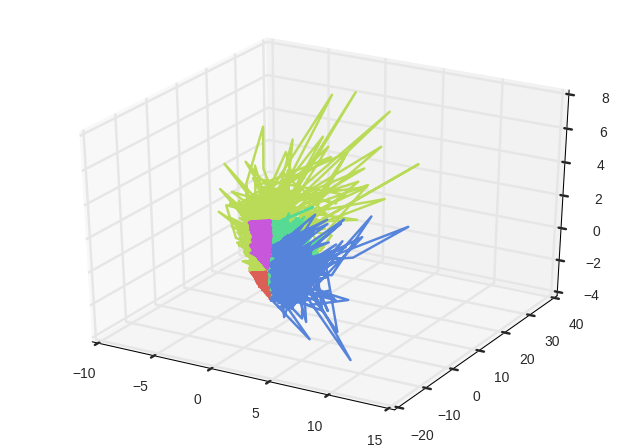

In [5]:
import hypertools as hyp
%matplotlib inline

cluster_labels = hyp.tools.cluster(data, n_clusters=5)
hyp.plot(data, group=cluster_labels)
#hyp.plot(data[[1,2,3,4,5]],'o',group= data.label, legend=list(set(data.label)))

In [6]:
data_sd = spark.read.csv('data.csv',header=True,inferSchema=True)

In [11]:
# count observations activities
for i in range(1,6):
    print 'activity %s : num_obs %i' %(i, data_sd.filter(data_sd['label']==i).count())
print 'people don\'t like so much to run...'

for p in range(1,9):
    print'\nPerson %s' %(p)
    for i in range(1,6):
        print 'activity %s : num_obs %i' %(i, data_sd.filter(data_sd['person_id']==p)\
                                           .filter(data_sd['label']==i).count())

activity 1 : num_obs 4807
activity 2 : num_obs 29372
activity 3 : num_obs 41846
activity 4 : num_obs 40570
activity 5 : num_obs 24831
people don't like so much to run...

Person 1
activity 1 : num_obs 527
activity 2 : num_obs 3563
activity 3 : num_obs 5800
activity 4 : num_obs 5317
activity 5 : num_obs 2529

Person 2
activity 1 : num_obs 657
activity 2 : num_obs 3666
activity 3 : num_obs 5943
activity 4 : num_obs 4571
activity 5 : num_obs 3574

Person 3
activity 1 : num_obs 550
activity 2 : num_obs 3009
activity 3 : num_obs 4900
activity 4 : num_obs 5865
activity 5 : num_obs 3116

Person 4
activity 1 : num_obs 607
activity 2 : num_obs 3529
activity 3 : num_obs 5813
activity 4 : num_obs 5257
activity 5 : num_obs 2620

Person 5
activity 1 : num_obs 679
activity 2 : num_obs 4495
activity 3 : num_obs 4102
activity 4 : num_obs 4504
activity 5 : num_obs 3140

Person 6
activity 1 : num_obs 585
activity 2 : num_obs 4390
activity 3 : num_obs 4411
activity 4 : num_obs 4645
activity 5 : num_obs 3

In [12]:
# repartition distributes the dataframe into x partitions.
print("Number of partition before repartition: {}".format(data_sd.rdd.getNumPartitions()))
data_sd=data_sd.repartition(4)
print("Number of partition after repartition: {}".format(data_sd.rdd.getNumPartitions()))

Number of partition before repartition: 3
Number of partition after repartition: 4


In [13]:
ignore = ['label','person_id']

assembler = VectorAssembler(
    inputCols=[x for x in data_sd.columns if x not in ignore],
    outputCol='features')

data_sd = assembler.transform(data_sd).select(['label', 'features']) 
# if have to use select because assembler simply appends the new columns

In [14]:
data_sd.show(5, truncate = False)

+-----+---------------------------------------------------------------------------------+
|label|features                                                                         |
+-----+---------------------------------------------------------------------------------+
|3    |[0.0199047773246,0.60247181629,-0.0128748934165,0.103795593567,0.05515676155]    |
|3    |[0.0475974339726,0.613626138749,-0.0158061658527,0.111281370571,0.0807137578044] |
|3    |[0.0181585704077,0.869505898736,-0.0950210008251,0.111931737829,0.175407160361]  |
|3    |[0.0108766716489,0.798018119239,2.86174099459E-4,0.0992467900453,0.0777358566241]|
|3    |[0.00128625924728,0.827159421587,0.00643555070932,0.115811913608,0.0887532321136]|
+-----+---------------------------------------------------------------------------------+
only showing top 5 rows



In [15]:
np.random.seed(0)
(trainingData_sd, valData_sd) = data_sd.randomSplit([0.7, 0.3])

dt = DecisionTreeClassifier()
model=dt.fit(trainingData_sd)

predictions_sd = model.transform(valData_sd)

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction")
accuracy = evaluator.evaluate(predictions_sd, {evaluator.metricName: 'accuracy'})
print 'Accuracy = %s \n...not bad' %(accuracy)
predictions_sd.show(1000)

Accuracy = 0.922506183017 
...not bad
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[-31.9219571248,2...|[0.0,63.0,10.0,0....|[0.0,0.7875,0.125...|       1.0|
|    1|[-20.7479957673,7...|[0.0,149.0,2.0,0....|[0.0,0.9141104294...|       1.0|
|    1|[-19.4132926792,6...|[0.0,149.0,2.0,0....|[0.0,0.9141104294...|       1.0|
|    1|[-19.3411703751,4...|[0.0,412.0,9.0,0....|[0.0,0.9786223277...|       1.0|
|    1|[-17.3339434836,7...|[0.0,149.0,2.0,0....|[0.0,0.9141104294...|       1.0|
|    1|[-16.7534813348,4...|[0.0,412.0,9.0,0....|[0.0,0.9786223277...|       1.0|
|    1|[-16.3370204578,7...|[0.0,149.0,2.0,0....|[0.0,0.9141104294...|       1.0|
|    1|[-16.2392193759,2...|[0.0,63.0,10.0,0....|[0.0,0.7875,0.125...|       1.0|
|    1|[-16.1297285709,6...|[0.0,149.0,2.0,0....|[0.0,0.9141

In [16]:
# But I have shown that with LOOcv and HMMs in scikit-learn the accuracy is quite bad instead! Let's try LOO here...
# I have to code it:
def loo(x):
    return [np.array(([x[i]],[el for el in x if el!=x[i]])) for i in range(len(x))]
loo_iter = loo(range(1,9))

In [19]:
data_sd = spark.read.csv('data.csv',header=True,inferSchema=True)
ignore = ['label','person_id']
data_sd = assembler.transform(data_sd).select(['label', 'features', 'person_id']) 

dt = DecisionTreeClassifier() 

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction", metricName='accuracy')

print 'Decision Tree Classifier'
for i in range(8):
    trainingData_sd = data_sd.where(col('person_id').isin(loo_iter[i][1]))
    valData_sd = data_sd.where(col('person_id').isin(loo_iter[i][0]))
    
    model = dt.fit(trainingData_sd)
    predictions_sd = model.transform(valData_sd)

    accuracy = evaluator.evaluate(predictions_sd)
    print 'Accuracy on left-out person %s = %g' %(i+1, accuracy)

Decision Tree Classifier
Accuracy on left-out person 1 = 0.664919
Accuracy on left-out person 2 = 0.952909
Accuracy on left-out person 3 = 0.905963
Accuracy on left-out person 4 = 0.773645
Accuracy on left-out person 5 = 0.902837
Accuracy on left-out person 6 = 0.790784
Accuracy on left-out person 7 = 0.954807
Accuracy on left-out person 8 = 0.828393


In [20]:
# HERE WITH RANDOM FORESTS

data_sd = spark.read.csv('data.csv',header=True,inferSchema=True)
ignore = ['label','person_id']
data_sd = assembler.transform(data_sd).select(['label', 'features', 'person_id']) 

labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(data_sd)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', maxCategories=4).fit(data_sd)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel",
                                              predictionCol="prediction", metricName="accuracy")

print 'Random Forest Classifier'
for i in range(8):
    trainingData_sd = data_sd.where(col('person_id').isin(loo_iter[i][1]))
    valData_sd = data_sd.where(col('person_id').isin(loo_iter[i][0]))
    
    model = pipeline.fit(trainingData_sd)
    predictions = model.transform(valData_sd)

    accuracy = evaluator.evaluate(predictions)
    print 'Accuracy on left-out person %s = %g' %(i+1, accuracy)

Random Forest Classifier
Accuracy on left-out person 1 = 0.96025
Accuracy on left-out person 2 = 0.964043
Accuracy on left-out person 3 = 0.920872
Accuracy on left-out person 4 = 0.838494
Accuracy on left-out person 5 = 0.913239
Accuracy on left-out person 6 = 0.777816
Accuracy on left-out person 7 = 0.957909
Accuracy on left-out person 8 = 0.905451


In [ ]:
data_sd = spark.read.csv('data.csv',header=True,inferSchema=True)
ignore = ['label','person_id']
data_sd = assembler.transform(data_sd).select(['label', 'features']) 

splits = data_sd.randomSplit([0.6, 0.4], 1234)
trainingData_sd = splits[0]
valData_sd = splits[1]
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
lay = [141426,2, 5]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=lay, featuresCol='features', labelCol='label')
# train the model
model = trainer.fit(trainingData_sd)

# compute accuracy on the test set
result = model.transform(valData_sd)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))